# Лабораторная работа 4

##  Вычисление и визуализация морфологического спектра

Разработать программу вычисления и визуализации морфологического спектра для бинарных и полутоновых изображений для различных структурирующих элементов (структурирующий элемент задается в виде аргумента).

Содержание отчета:
- Исходные изображения
- Код программы (для Jupyter Notebook)
- Результат работы программы
- Срок: 1.04.2025

In [12]:
%pylab inline
import skimage.io
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
from numpy import ceil
from skimage.color import rgb2gray
from skimage.morphology import closing, opening, binary_dilation
from scipy.ndimage import binary_erosion, binary_dilation, binary_closing, binary_opening

Populating the interactive namespace from numpy and matplotlib


In [13]:
def print_images(imgs, *, n_cols=None, fig_dim=None):
    if isinstance(imgs, np.ndarray):
        imgs = [imgs]
    num_imgs = len(imgs)
    if num_imgs == 1:
        n_rows, n_cols = 1, 1
        fig_dim = fig_dim or 5
    else:
        n_cols = n_cols or min(num_imgs, 3)
        n_rows = ceil(num_imgs / n_cols)
        fig_dim = fig_dim or 15
    figsize = (fig_dim, fig_dim / n_cols * n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.atleast_1d(axes).flatten()
    for ax, img in zip(axes, imgs):
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None, interpolation='none')
        ax.axis('off')
    for ax in axes[num_imgs:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

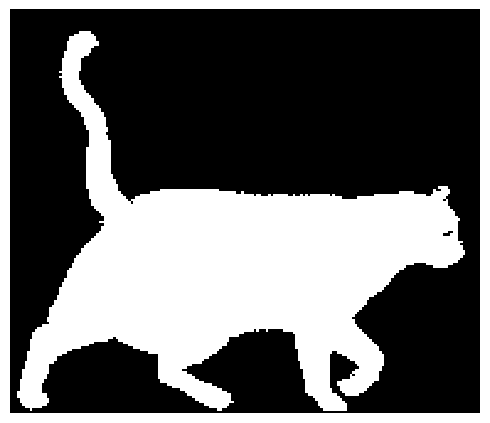

In [14]:
img = (imread('binary.png') > 0.5)
if len(img.shape) == 3:
    img = img[:, :, 0]
print_images(img)

In [15]:
struct_el = np.ones((3, 3))

In [16]:
def bin_spectrum(image, B, max_iter=30):
    xs = []
    ys = []
    radius = max(B.shape) // 2  # Радиус для паддинга

    def update_struct_element(B_curr):
        """Обновление структурного элемента"""
        return binary_dilation(pad(B_curr, radius, "constant"), B)

    def compute_cross_difference(img1, img2):
        """Вычисление разницы между двумя изображениями"""
        return np.count_nonzero(np.logical_and(~img1, img2))

    # Первая часть: анализ с отрицательными итерациями
    B_curr = np.array([[True]])
    for i in range(1, max_iter):
        img_curr = binary_closing(image, B_curr)
        B_curr = update_struct_element(B_curr)
        img_next = binary_closing(image, B_curr)

        # Вычисляем количество изменений
        count = compute_cross_difference(img_curr, img_next)

        if count == 0:  # Если изменений нет, выходим из цикла
            break
        xs.append(-i)
        ys.append(count)

    # Вторая часть: анализ с положительными итерациями
    B_curr = np.array([[True]])
    for i in range(max_iter):
        if not np.any(binary_erosion(image, B_curr)):  # Если нет изменений после эрозии, выходим
            break

        img_curr = binary_opening(image, B_curr)
        B_curr = update_struct_element(B_curr)
        img_next = binary_opening(image, B_curr)

        # Вычисляем количество изменений
        count = compute_cross_difference(img_next, img_curr)

        xs.append(i)
        ys.append(count)

    return xs, ys

<BarContainer object of 41 artists>

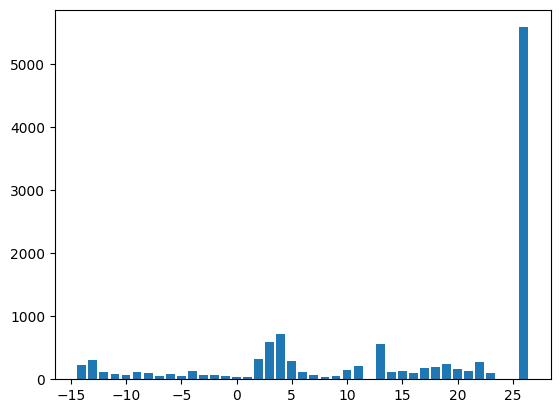

In [17]:
xs, ys = bin_spectrum(img, struct_el)
plt.bar(xs, ys)

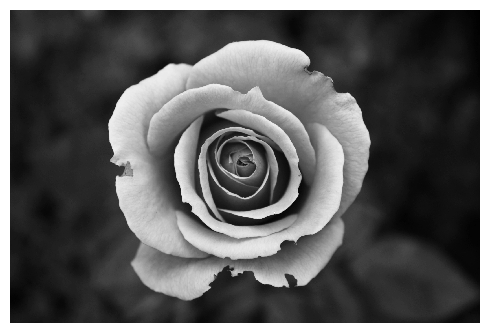

In [18]:
img_gray = imread('rose.jpg')[::2, ::2, 0]
print_images(img_gray)

In [19]:
def gray_spectrum(image, B, max_iter=10):
    """
    Compute the gray-scale morphological spectrum of an image using closing and opening operations.

    :param image: Input image (grayscale or RGB)
    :param B: Structuring element (binary mask)
    :param max_iter: Maximum number of iterations for morphological operations
    :return: Tuple (xs, ys) where xs are scales and ys are changes at each scale
    """
    # Convert to grayscale if needed
    if image.ndim == 3:
        image = rgb2gray(image)

    radius = max(B.shape) // 2
    xs, ys = [], []
    # Closing (negative scales)
    B_curr = np.array([[True]], dtype=bool)
    for i in range(1, max_iter + 1):
        img_curr = closing(image, B_curr)
        B_curr = binary_dilation(pad(B_curr, radius , "constant"), B)  # Expand structuring element
        img_next = closing(image, B_curr)
        img_cross = img_next - img_curr
        count = np.sum(img_cross)

        if count == 0:
            break  # Stop if no contribution

        xs.append(-i)
        ys.append(count)

    # Opening (positive scales)
    B_curr = np.array([[True]], dtype=bool)
    for i in range(max_iter):
        img_curr = opening(image, B_curr)
        B_curr = binary_dilation(pad(B_curr, radius , "constant"), B)  # Expand structuring element
        img_next = opening(image, B_curr)
        img_cross = img_curr - img_next
        count = np.sum(img_cross)

        if count <= 0:
            break  # Stop if no contribution

        xs.append(i)
        ys.append(count)

    return xs, ys

<BarContainer object of 40 artists>

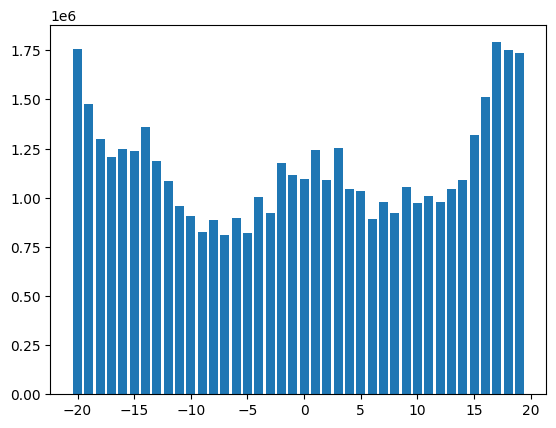

In [20]:
B = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=bool)
xs, ys = gray_spectrum(img_gray, B, 20)
bar(xs, ys)